## TP2: Visión por Computadora I (CEIA)
### Nombre: Pablo Segovia

Implementar la función create_gauss_filter(h, w, k_size, sigma)para crear filtros gaussianos para
filtrado espectral. Debe retornar un filtro gaussiano de tamaño HxW en dominio espacial y su transformada
de Fourier.

1. Graficar ambas representaciones para diferentes tamaños de kernel y sigma. Aplicar el filtro una
imagen para validar el funcionamiento en el dominio espectral.
2. Usando el método descripto en el paper“Image Sharpness Measure for Blurred Images in Frequency
Domain” comparar el resultado de un filtrado por convolución con el filtrado espectral.
3. Repetir la comparación usando uno de los métodos descriptos en el apéndice del paper “Analysis of
focus measure operators in shape-from-focus”

In [1]:
# Importamos las librerías a utilizar
import numpy as np
import matplotlib.pyplot as plt
import cv2 as cv

In [12]:
# Generamos la función que pide la consigna
def create_gauss_filter(h, w, k_size, sigma):
    # Generar el kernel gaussiano
    gaussian = cv.getGaussianKernel(ksize=k_size, sigma=sigma)
    
    # Transformar gaussiano en matricial
    gaussian = gaussian @ gaussian.T
    
    # Calculamos el tamaño del padding en ambas direcciones
    pad_w = (w-k_size)//2
    pad_h = (h-k_size)//2 +1
    
    # Realizar un padding completando con ceros el kernel
    gaussian = np.pad(gaussian, pad_width=((pad_h,pad_h),(pad_w,pad_w)), mode='constant', constant_values=0)

    # Chequear si es par, tanto h como w, y corregir la última columna
    if (w % 2) == 0:
        gaussian=gaussian[:,0:-1]
    if (h % 2) == 0:
        gaussian=gaussian[0:-1,:]
    
    # Pasar el gaussiano por su transformada de furier 2D
    gaussian_fft = np.fft.fft2(gaussian)
    
    return gaussian, gaussian_fft
    
    

1. Graficar ambas representaciones para diferentes tamaños de kernel y sigma. Aplicar el filtro una
imagen para validar el funcionamiento en el dominio espectral.

#### Probamos una imagen para ver su impacto

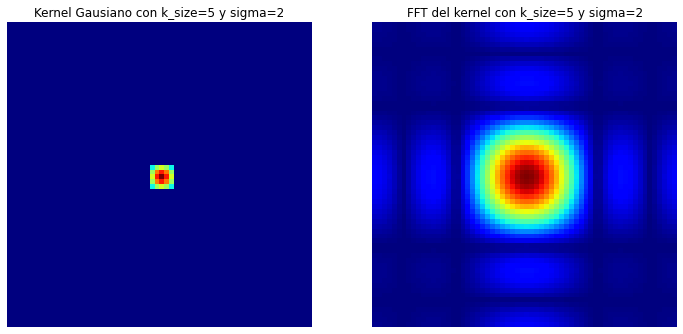

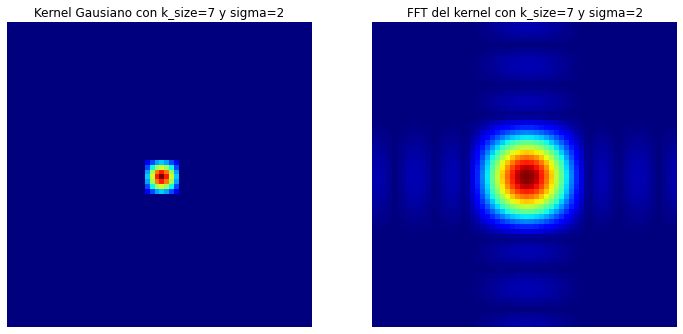

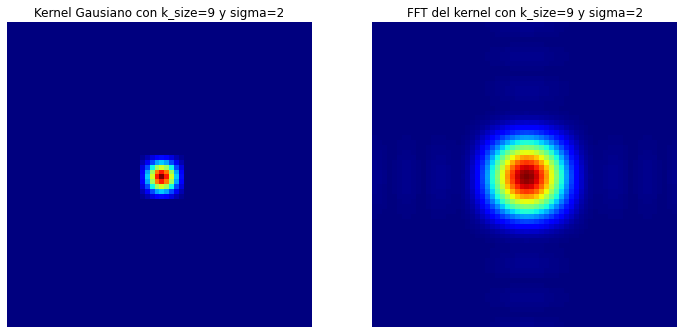

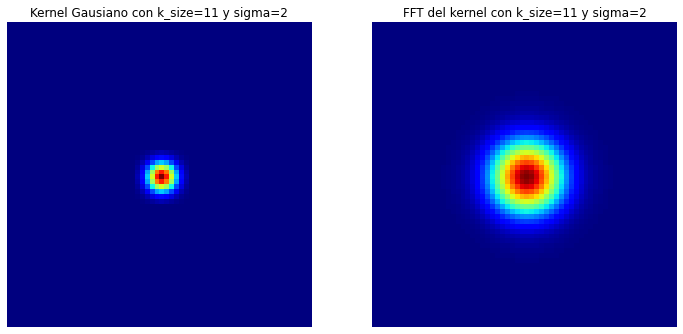

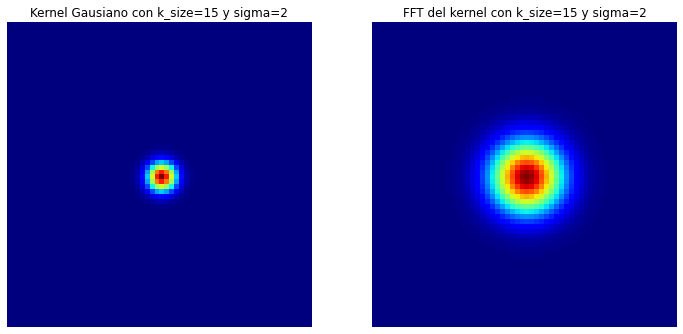

In [3]:
# Probamos diferentes tamaños de kernels
for size in [5, 7, 9, 11, 15]:
    kernel, kernel_tf = create_gauss_filter(h=64, w=64, k_size=size, sigma=2)

    plt.figure(figsize=(12,12))
    plt.subplot(1,2,1)
    plt.axis('off')
    plt.title(f"Kernel Gausiano con k_size={size} y sigma={2}")
    plt.imshow(kernel, cmap='jet')
    plt.subplot(1,2,2)
    plt.axis('off')
    plt.title(f"FFT del kernel con k_size={size} y sigma={2}")
    tf_shifted = np.fft.fftshift(kernel_tf)
    plt.imshow(np.abs(tf_shifted), cmap='jet');

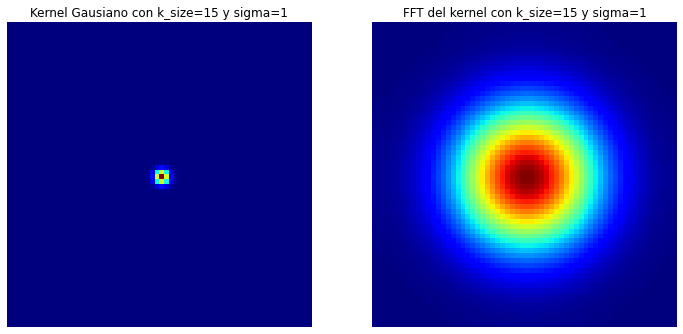

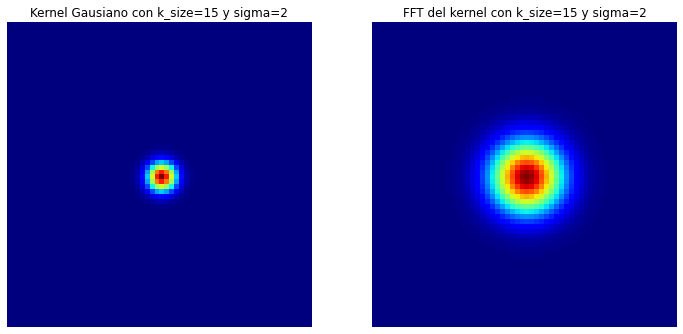

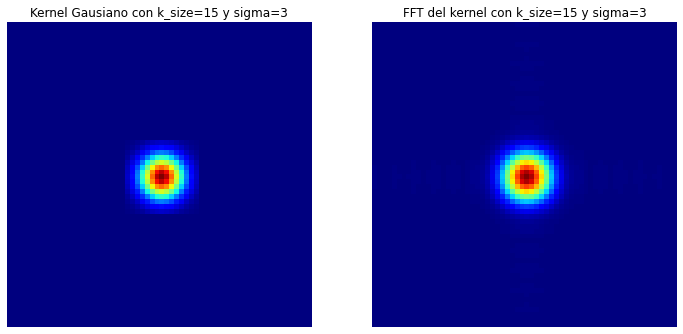

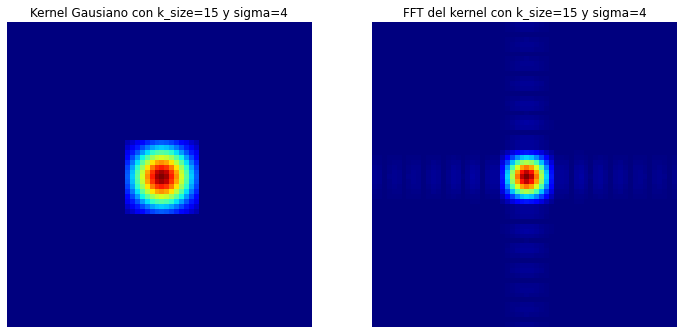

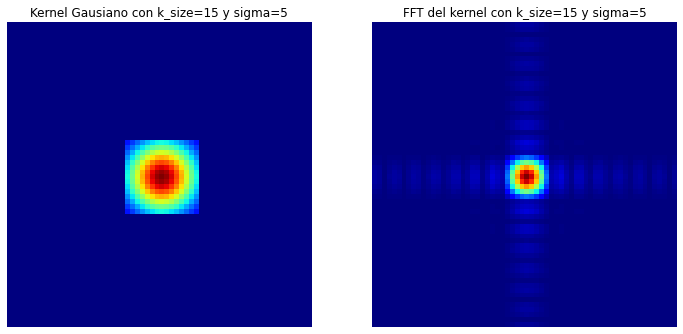

In [4]:
# Probamos diferentes sigmas
for sigma in [1, 2, 3, 4, 5]:
    kernel, kernel_tf = create_gauss_filter(h=64, w=64, k_size=15, sigma=sigma)

    plt.figure(figsize=(12,12))
    plt.subplot(1,2,1)
    plt.axis('off')
    plt.title(f"Kernel Gausiano con k_size={15} y sigma={sigma}")
    plt.imshow(kernel, cmap='jet')
    plt.subplot(1,2,2)
    plt.axis('off')
    plt.title(f"FFT del kernel con k_size={15} y sigma={sigma}")
    tf_shifted = np.fft.fftshift(kernel_tf)
    plt.imshow(np.abs(tf_shifted), cmap='jet');

- Completar explicación.

In [13]:
# Importamos la imagen así conocemos h y w
img = cv.imread('fft_alfa_pred.png', 0)

In [14]:
h,w = img.shape
kernel, kernel_tf = create_gauss_filter(h, w, k_size=15, sigma=3.0)

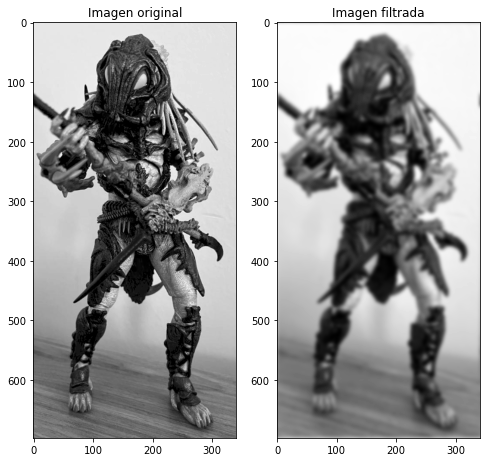

In [15]:
# Definir la imagen en el dominio de los complejos
img_fft = np.fft.fft2(img)

# Aplicar el kernel gaussiano
img_fft = img_fft * kernel_tf

# Aplicamos la antitransformada y obtenemos las imagenes filtradas
img_fft = np.fft.ifftshift(np.real(np.fft.ifft2(img_fft)))

plt.figure(figsize=(8,8))
plt.subplot(1,2,1)
plt.imshow(img, cmap='gray')
plt.title('Imagen original')
plt.subplot(1,2,2)
plt.title('Imagen filtrada')
plt.imshow(img_fft, cmap='gray');

2. Usando el método descripto en el paper“Image Sharpness Measure for Blurred Images in Frequency
Domain” comparar el resultado de un filtrado por convolución con el filtrado espectral.

In [16]:
def calcular_image_quality(img):    
    # Calcular la representación de la Transformada de Fourier de la imagen
    F = np.fft.fft2(img)

    # Calcular Fc
    Fc = np.fft.fftshift(F)

    # Calcular AF
    AF = np.abs(Fc)

    # Calcular M
    M = np.max(AF)

    # Calcular TH: número total de píxeles en F cuyo valor de píxel > umbral
    umbral = M / 1000
    TH = np.sum(AF > umbral)

    # Calcular la Medida de Calidad de Imagen (FM)
    FM = TH / (img.shape[0] * img.shape[1])
    
    return FM
    
    

In [17]:
# Calculamos diferentes imagenes con diferentes sigmas
def calc_img_sigmas(img, sigma):
    kernel, kernel_tf = create_gauss_filter(h, w, k_size=15, sigma=sigma)
    # Definir la imagen en el dominio de los complejos
    img_fft = np.fft.fft2(img)

    # Aplicar el kernel gaussiano
    img_fft = img_fft * kernel_tf

    # Aplicamos la antitransformada y obtenemos las imagenes filtradas
    img_fft = np.fft.ifftshift(np.real(np.fft.ifft2(img_fft)))
    
    return kernel, img_fft

In [25]:
# Generamos las imagenes vs los sigmas
fms = []
sigmas = [1, 2, 3, 5, 7]

for sigma in sigmas:
    _, img_fft = calc_img_sigmas(img, sigma)
    fm = calcular_image_quality(img_fft)
    fms.append(fm)
    
sigmas.insert(0,0)
fms.insert(0,calcular_image_quality(img))

In [26]:
print(len(fms))

6


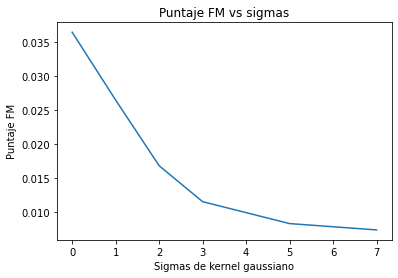

In [19]:
# Graficamos los puntajes de las imágenes vs los sigma
plt.figure()
plt.plot(sigmas, fms)
plt.title('Puntaje FM vs sigmas')
plt.xlabel('Sigmas de kernel gaussiano')
plt.ylabel('Puntaje FM')
plt.show()

6


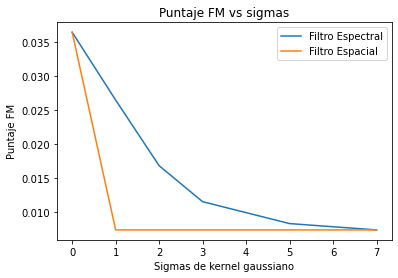

In [27]:
# Generamos las imagenes usando un filtro 2D
# Definimos una función para aplicar un filtro
def filtro_desenfoque(img, kernel):
    return cv.filter2D(img, -1, kernel)

# Generamos las imagenes vs los sigmas
fms_des = []
sigmas = [1, 2, 3, 5, 7]

for sigma in sigmas:
    kernel, _ = calc_img_sigmas(img, sigma)
    img_des = filtro_desenfoque(img, kernel)
    fm_des = calcular_image_quality(img_fft)
    fms_des.append(fm_des)

print(len(fms))

sigmas.insert(0,0)
fms_des.insert(0,calcular_image_quality(img))

# Graficamos los puntajes de las imágenes vs los sigma
plt.figure()
plt.plot(sigmas, fms, label='Filtro Espectral')
plt.plot(sigmas, fms_des, label='Filtro Espacial')
plt.title('Puntaje FM vs sigmas')
plt.xlabel('Sigmas de kernel gaussiano')
plt.ylabel('Puntaje FM')
plt.legend()
plt.show()


3. Repetir la comparación usando uno de los métodos descriptos en el apéndice del paper “Analysis of
focus measure operators in shape-from-focus”

In [31]:
# Usamos el focus measure operator: Gradient Energy (A.11 del paper)
def gradient_energy(img):
    # Calcular el gradiente en las direcciones x e y
    gradient_x = cv.Sobel(img, cv.CV_64F, 1, 0, ksize=3)
    gradient_y = cv.Sobel(img, cv.CV_64F, 0, 1, ksize=3)

    # Calcular la energía del gradiente como la suma de los cuadrados de los gradientes en x e y
    energy = np.sum(gradient_x**2 + gradient_y**2)

    return energy

In [32]:
# Generamos las imagenes vs los sigmas
gr_ens = []
gr_ens_des = []
sigmas = [1, 2, 3, 5, 7]

for sigma in sigmas:
    kernel, img_fft = calc_img_sigmas(img, sigma)
    gr_en = gradient_energy(img_fft)
    gr_ens.append(gr_en)

    img_des = filtro_desenfoque(img, kernel)
    gr_en_des = gradient_energy(img_des)
    gr_ens_des.append(gr_en_des)
    
sigmas.insert(0,0)
gr_ens.insert(0,gradient_energy(img))
gr_ens_des.insert(0,gradient_energy(img))

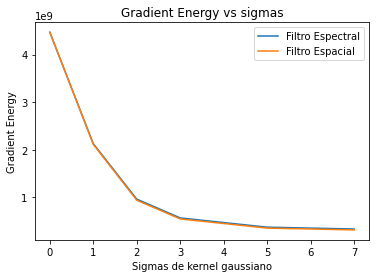

In [33]:
# Graficamos los gradient energies de las imágenes vs los sigma
plt.figure()
plt.plot(sigmas, gr_ens, label='Filtro Espectral')
plt.plot(sigmas, gr_ens_des, label='Filtro Espacial')
plt.title('Gradient Energy vs sigmas')
plt.xlabel('Sigmas de kernel gaussiano')
plt.ylabel('Gradient Energy')
plt.legend()
plt.show()